#**Mask detection using transfer learning based on InceptionV3 NN**
###Tianyi Liang

---




##Import necessary packages

In [1]:
!pip install opendatasets
!pip install opencv-python
!pip install opencv-contrib-python

import gc
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import opendatasets as od

from cv2 import cv2
from matplotlib import pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation, Input, Add, \
                   BatchNormalization, Flatten, Conv2D, \
                   AveragePooling2D, MaxPooling2D, ZeroPadding2D

## Download the dataset in public domain of Kaggle
####( https://www.kaggle.com/datasets/ashishjangra27/face-mask-12k-images-dataset uploaded by ASHISH JANGRA)
---

In [2]:
od.download("https://www.kaggle.com/datasets/ashishjangra27/face-mask-12k-images-dataset")
root_path = "face-mask-12k-images-dataset/Face Mask Dataset/"

Skipping, found downloaded files in "./face-mask-12k-images-dataset" (use force=True to force download)


## Read the data into memory
---

In [3]:
dataset = {"path": [], "classification": [], "set": [], "value": []}

# Train or test folder
for train_test in os.listdir(root_path):

    # Mask or WithoutMask folder
    for true_false in os.listdir(root_path+"/"+train_test):

        # Each image inside
        for image in glob.glob(root_path + 
                     train_test + "/" + 
                     true_false + "/" + 
                     "*.png"):

            this_path = str(root_path + 
                     train_test + "/" + 
                     true_false + "/" + 
                     image)
            img = cv2.imread(image, 3)
            img = np.asarray(cv2.resize(img, 
                    dsize=(224, 224)))
            img = cv2.merge(cv2.split(img)[::-1])
            dataset["path"].append(image)
            if true_false == "WithMask":
                dataset["classification"].append(np.uint8(1))
            else:
                dataset["classification"].append(np.uint8(0))
            dataset["set"].append(train_test.lower())
            dataset["value"].append(img)

df_dataset = pd.DataFrame(dataset)
df_dataset.head()

,path,classification,set,value
0,face-mask-12k-images-dataset/Face Mask Dataset...,1,validation,"[[[230, 203, 196], [230, 203, 196], [230, 203,..."
1,face-mask-12k-images-dataset/Face Mask Dataset...,1,validation,"[[[164, 159, 157], [178, 172, 170], [185, 179,..."
2,face-mask-12k-images-dataset/Face Mask Dataset...,1,validation,"[[[2, 0, 0], [6, 0, 0], [42, 28, 22], [42, 28,..."
3,face-mask-12k-images-dataset/Face Mask Dataset...,1,validation,"[[[75, 44, 23], [84, 48, 27], [84, 48, 27], [8..."
4,face-mask-12k-images-dataset/Face Mask Dataset...,1,validation,"[[[211, 200, 200], [211, 198, 200], [209, 198,..."


## Take a look at the data 
### All images will be upsample/downsample to dimension **224 X 224 X 3** at this point.
---

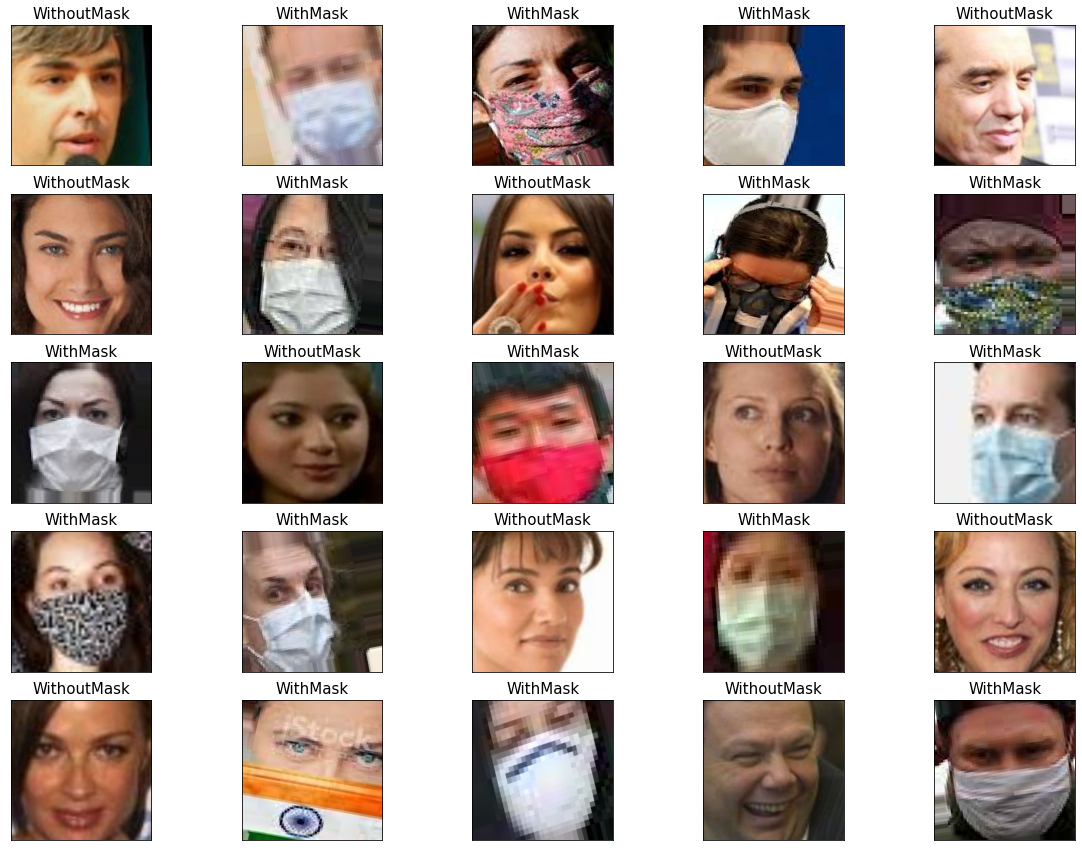

In [4]:
plt.figure(figsize = (20, 15))
np.random.seed(1)
sample = np.random.choice(range(len(df_dataset)), size=25, replace=False)
for i in range(25):
    plt.subplot(5, 5, i+1)
    img = df_dataset.loc[sample[i],"value"]
    plt.imshow(img)
    classification = 'WithMask' if df_dataset.loc[sample[i],"classification"] == 1 else "WithoutMask"
    plt.title(classification, size = 15)
    plt.xticks([])
    plt.yticks([])
plt.show()

## Perform max normalization on the data and format the data into the shape I need.
---

In [5]:
def set_seed():
    InitSeed = 23
    tf.random.set_seed(InitSeed)
    np.random.seed(InitSeed)


train_set = pd.DataFrame(df_dataset[df_dataset["set"] == "train"]).loc[:, ["value", "classification"]]
test_set = pd.DataFrame(df_dataset[df_dataset["set"] == "test"]).loc[:, ["value", "classification"]]
valid_set = pd.DataFrame(df_dataset[df_dataset["set"] == "validation"]).loc[:, ["value", "classification"]]

x_train = np.asarray(train_set["value"].tolist()) / 255
y_train = np.asarray(train_set["classification"].tolist())
x_test = np.asarray(test_set["value"].tolist()) / 255
y_test = np.asarray(test_set["classification"].tolist())
x_valid = np.asarray(valid_set["value"].tolist()) / 255
y_valid = np.asarray(valid_set["classification"].tolist())

del df_dataset, train_set, test_set, valid_set, img, dataset, this_path
del glob, od, pd, cv2
gc.collect()
print("x_train dimension:", x_train.shape, "\ny_train dimension:", y_train.shape,
   "\nx_test dimension:", x_test.shape, "\ny_test dimension:", y_test.shape,
   "\nx_valid dimension:", x_valid.shape, "\ny_valid dimension:", y_valid.shape,)

x_train dimension: (10000, 224, 224, 3) 
y_train dimension: (10000,) 
x_test dimension: (992, 224, 224, 3) 
y_test dimension: (992,) 
x_valid dimension: (800, 224, 224, 3) 
y_valid dimension: (800,)


## Take a look at the balance of the data

---



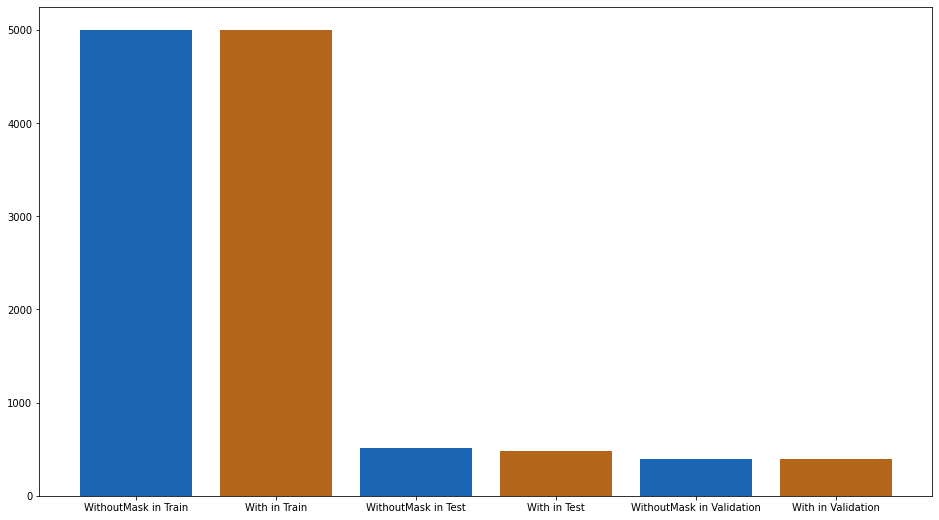

In [6]:
classes_distribution = {"WithoutMask in Train": np.sum(y_train == 0), 
              "With in Train": np.sum(y_train == 1),
              "WithoutMask in Test": np.sum(y_test == 0),
              "With in Test": np.sum(y_test == 1),
              "WithoutMask in Validation": np.sum(y_valid == 0),
              "With in Validation": np.sum(y_valid == 1)}
plt.figure(figsize = (16, 9))
color_A = (0.1, 0.4, 0.7)
color_B = color_A[::-1]
plt.bar(range(len(classes_distribution)), 
        list(classes_distribution.values()), 
        tick_label=list(classes_distribution.keys()),
        color=[color_A, color_B])
plt.show()
plt.show()

## Implement image augmentation to put off overfitting
---

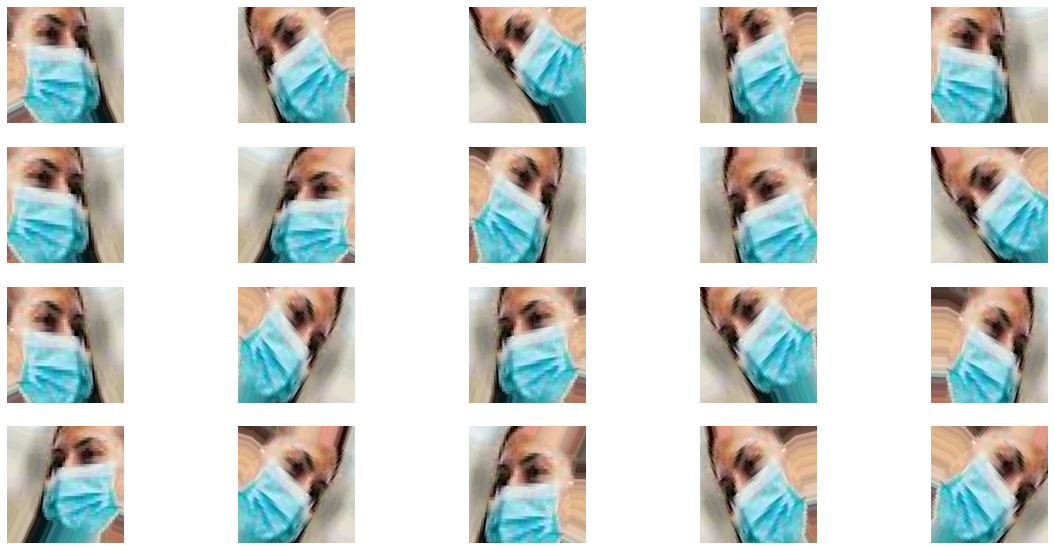

49728

In [7]:
set_seed()
train_aug = ImageDataGenerator(
    rotation_range=30,
    height_shift_range=.1,
    width_shift_range=.1,
    zoom_range=.1,
    horizontal_flip=True,
)
augment = train_aug.flow(x_train[0:1], batch_size=1)

# Check if the augmentation works
plt.figure(figsize = (20, 15))
for i in range(1, 26):
    plt.subplot(1 + 5 % i, 5, i)
    tf.random.set_seed(1)
    augment.reset()
    plt.imshow(augment.next().squeeze(), cmap='gray')
    plt.axis('off')
plt.show()

del augment
gc.collect()

##Start building the network


*   Implement InceptionV3 from Keras Application
*   Implement self-designed W&DNN on the output of InceptionV3
> *    Dense Layers
> *    Choose of Kernel Initializers
> *    Batch Normalization Layers
> *    Choose of Activation Func
> *    Dropout Layers
*   Choose optimized compile options
*   Implement self-designed learning rate scheduler



---

In [8]:
def classifier_(input_):
    initializer = tf.keras.initializers.GlorotNormal(seed=767)
    output_ = keras.layers.GlobalAveragePooling2D()(input_)
    output_ = keras.layers.Flatten()(output_)
    output_ = keras.layers.BatchNormalization()(output_)
    output_prime = output_

    output_ = keras.layers.Dense(2048, kernel_initializer=initializer)(output_)
    output_ = keras.layers.BatchNormalization()(output_)
    output_ = keras.layers.Activation('relu')(output_)
    output_ = keras.layers.Dropout(0.55)(output_)

    output_ = keras.layers.Dense(2048, kernel_initializer=initializer)(output_)
    output_ = keras.layers.BatchNormalization()(output_)
    output_ = keras.layers.Activation('relu')(output_)
    output_ = keras.layers.Dropout(0.55)(output_)

    output_ = keras.layers.Dense(1024, kernel_initializer=initializer)(output_)
    output_ = keras.layers.BatchNormalization()(output_)
    output_ = keras.layers.Activation('relu')(output_)
    output_ = keras.layers.Dropout(0.55)(output_)

    output_ = keras.layers.Concatenate()([output_, output_prime])

    output_ = keras.layers.Dense(512, activation='relu', kernel_initializer=initializer)(output_)
    output_ = keras.layers.Dense(2, activation='softmax')((output_))
    return output_


def model_flow(input_):
    output_ = tf.keras.applications.InceptionV3(input_shape=(224, 224, 3),
                               include_top=False,
                               weights=None)(input_)

    # output_ a fc1000 classification at this point
    # Add the self-designed classifier to produce binary result
    output_ = classifier_(output_)
    return output_


def input_output_compile():

    # Shape of the training set
    input_ = keras.layers.Input(shape=(224, 224, 3))
    output_ = model_flow(input_)
    clf = keras.Model(inputs=input_, outputs=output_)

    clf.compile(optimizer='SGD', loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
    return clf


# Define learning rate scheduler
def lr_decay(epoch, lr):
    if epoch == 0:

        # Do not print evaluation at the beginning of the training

        return lr * 1 / (1 + 0.05 * epoch)
    if epoch % 5 == 0:
        
        # Print test accuracy every 5 epochs
        print('Test set accuracy: ' +
              str(np.round(model.evaluate(x_test, y_test)[1] * 100, 2)) + '%')
    return lr * 1 / (1 + 0.05 * epoch)


### Take a look at the structure of the model
---

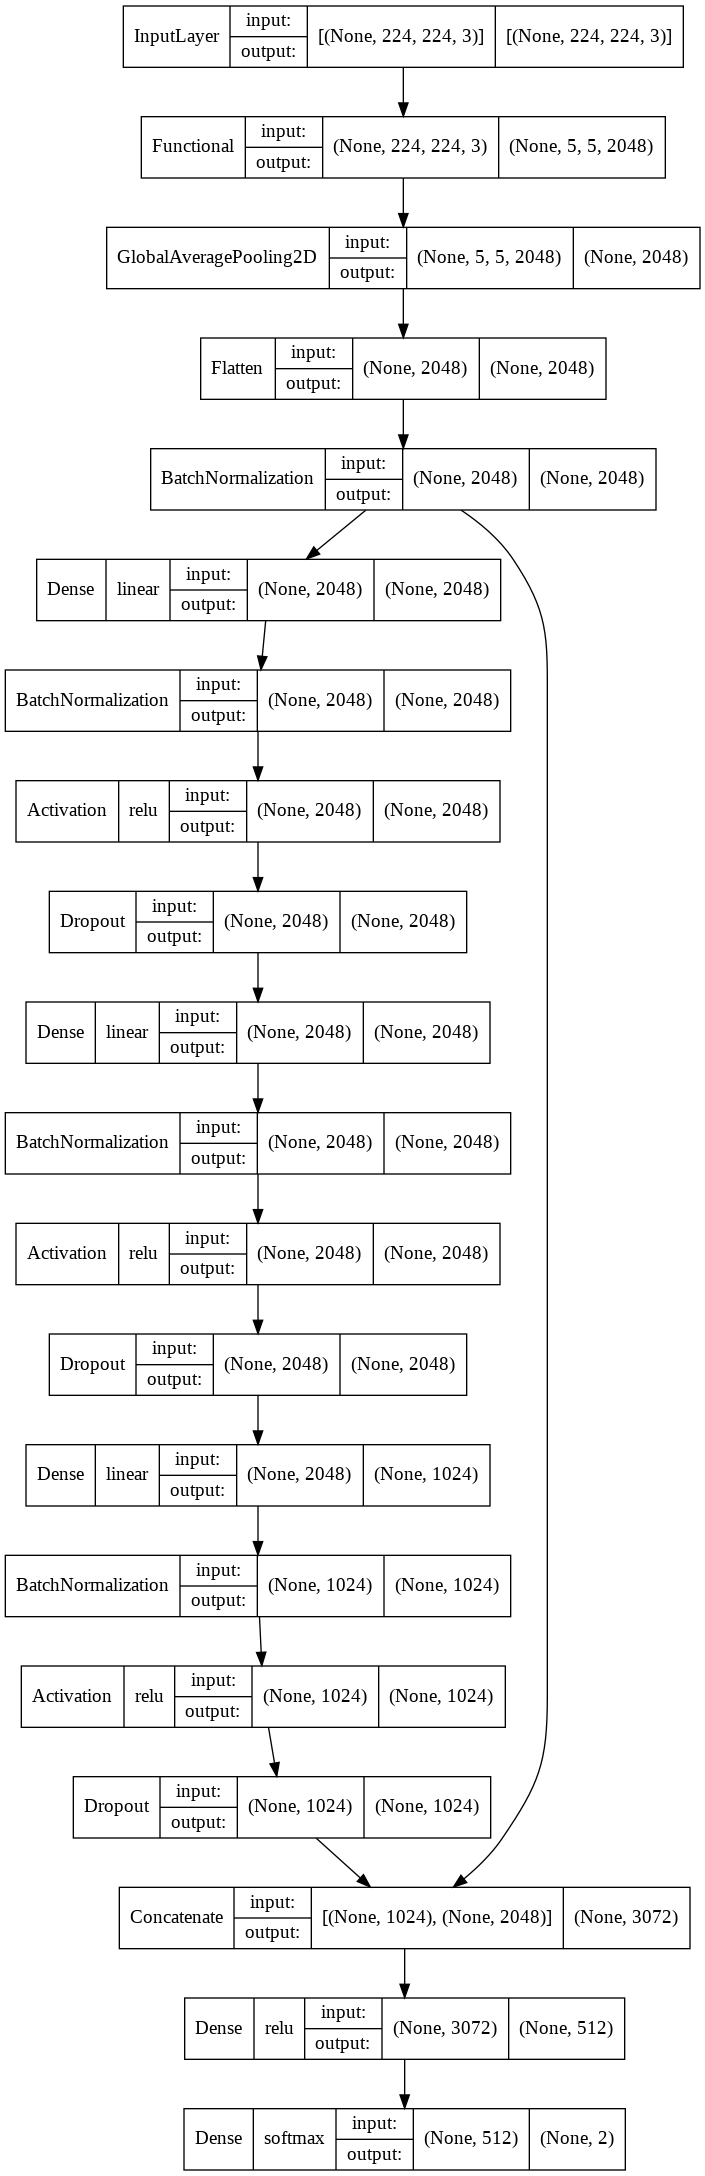

In [9]:
set_seed()
model = input_output_compile()
tf.keras.utils.plot_model(model, show_shapes=True,
              show_dtype=False,
              show_layer_names=False,
              show_layer_activations=True)

## Start the training on augmentation generater
---

In [10]:
set_seed()
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_decay)
hist = model.fit_generator(train_aug.flow(x_train, y_train, batch_size=24),
                    epochs=8,
                    # steps_per_epoch=X_train.shape[0]//batch_size,
                    validation_data=(x_valid, y_valid),
                    # validation_steps=X_valid.shape[0]//batch_size
                    callbacks=[lr_scheduler])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/8
417/417 [==============================] - 114s 251ms/step - loss: 0.3631 - accuracy: 0.8630 - val_loss: 0.2759 - val_accuracy: 0.8875 - lr: 0.0100
Epoch 2/8
417/417 [==============================] - 100s 240ms/step - loss: 0.1764 - accuracy: 0.9354 - val_loss: 0.0919 - val_accuracy: 0.9712 - lr: 0.0095
Epoch 3/8
417/417 [==============================] - 100s 241ms/step - loss: 0.1389 - accuracy: 0.9517 - val_loss: 0.1127 - val_accuracy: 0.9600 - lr: 0.0087
Epoch 4/8
417/417 [==============================] - 101s 242ms/step - loss: 0.1150 - accuracy: 0.9599 - val_loss: 0.0858 - val_accuracy: 0.9712 - lr: 0.0075
Epoch 5/8
31/31 [==============================] - 1s 32ms/step - loss: 0.0756 - accuracy: 0.9718
Test set accuracy: 97.18%
Epoch 6/8
417/417 [==============================] - 100s 240ms/step - loss: 0.0869 - accuracy: 0.9686 - val_loss: 0.0532 - val_accuracy: 0.9837 - lr: 0.0050
Epoch 7/8
417/417 [==============================] - 100s 240ms/step - loss: 0.0698 - 

## Visualize the change of accuracy and loss during the training
---

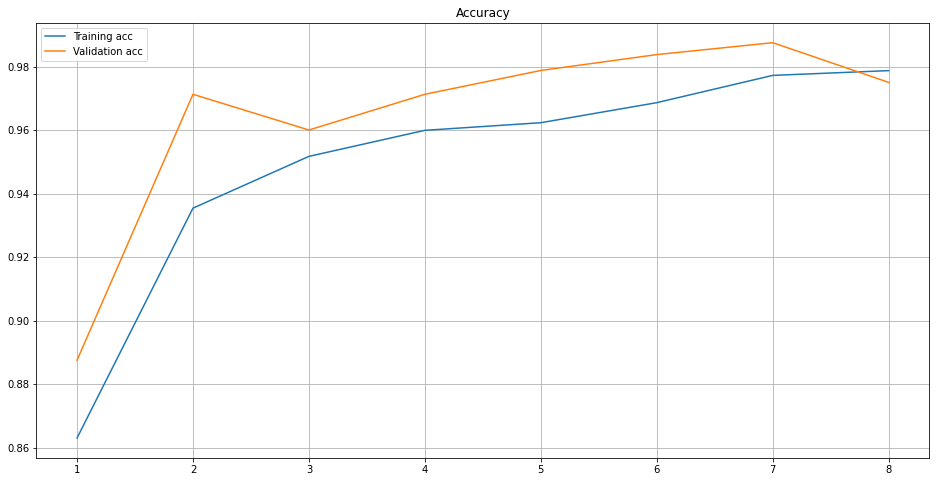

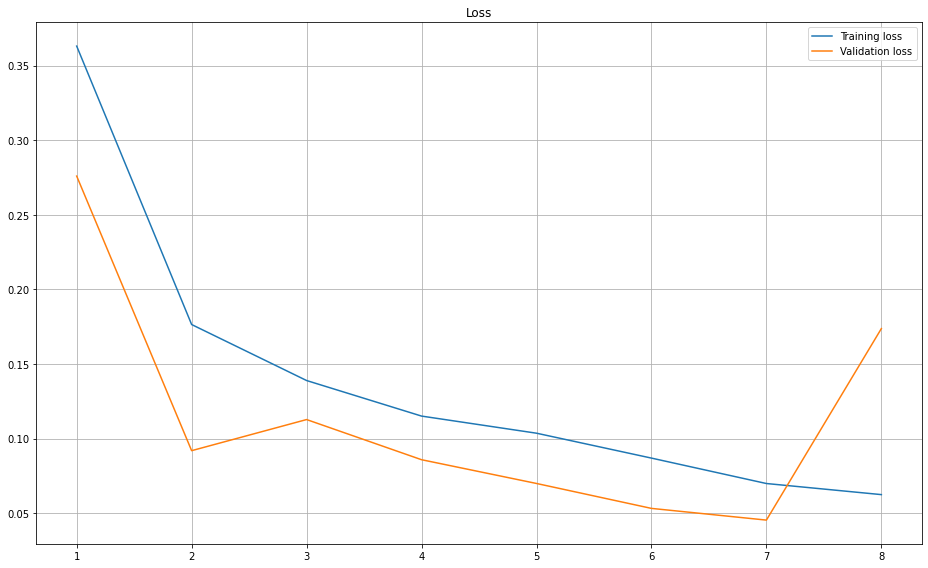

In [11]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.figure(figsize = (16, 8))
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Accuracy')
plt.legend()
plt.grid()
plt.figure(figsize = (13, 8))
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

## Evaluate the result and analyze wrong cases
> *    Plot wrong-predicted images
> *    Calculate TN, FN, TP, FP
> *    Calculate Reall, Precision, Specificity Rates
---

In [12]:
model.evaluate(x_test, y_test)

31/31 [==============================] - 1s 33ms/step - loss: 0.1385 - accuracy: 0.9728


[0.13849849998950958, 0.9727822542190552]

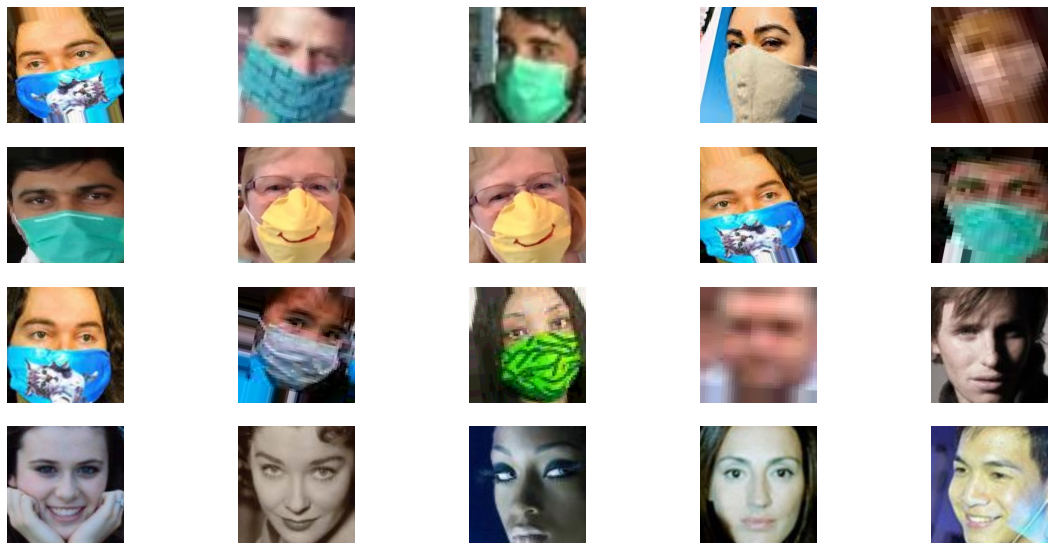

In [15]:
y_pred = model.predict(x_test)
correct_ = np.equal(np.argmax(y_pred, 1), y_test)
x_wrong = x_test[np.logical_not(correct_)]
from re import X
# Check if the augmentation works
plt.figure(figsize = (20, 15))
for i in range(1, len(x_wrong)-1):
    plt.subplot(1 + 5 % i, 5, i)
    plt.imshow(x_wrong[i].squeeze(), cmap='gray')
    plt.axis('off')
plt.show()

In [14]:
y_pred = np.argmax(y_pred, 1)
TP = np.sum(np.logical_and(y_pred == 0, y_test == 0))
FP = np.sum(np.logical_and(y_pred == 0, y_test == 1))
TN = np.sum(np.logical_and(y_pred == 1, y_test == 1))
FN = np.sum(np.logical_and(y_pred == 1, y_test == 0))
print('TP:', TP, '\nFP:', FP, '\nTN:', TN, '\nFN:', FN)
print("\nFP: predict as WithoutMask but actually WithMask",
   "\nFN: predict as WithMask but actually WithoutMask")

# IMPORTANT when false ALARM is unacceptable
precision = str(np.round((TP/(TP+FP))*100, 2)) + "%"

# IMPORTANT when missing ALARM is unacceptable, 
# rather have some fake ALARM
recall = str(np.round((TP/(TP+FN))*100, 2)) + "%"

# IMPORTANT when false ALARM is unacceptable
specificity = str(np.round((TN/(TN+FP))*100, 2)) + "%"

print("\nPrecision:", precision,"\nRecall:", recall,
    "\nSpecificity:", specificity)

TP: 502 
FP: 20 
TN: 463 
FN: 7

FP: predict as WithoutMask but actually WithMask 
FN: predict as WithMask but actually WithoutMask

Precision: 96.17% 
Recall: 98.62% 
Specificity: 95.86%
